<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<img src="./logo.png" alt="class.vision" style="width: 200px;"/>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">طبقه بندی ویدیو با شبکه‌های بازگشتی</div></center></h1>

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">لود کتابخانه‌های مورد استفاده</div>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop

import os
import csv
import numpy as np

print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


Using TensorFlow backend.


## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">تعریف متغیرها</div>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
تعیین کردن مسیر مجموعه داده، تعداد فریم‌ها برای تشخیص یک ویدیو (تعداد step های زمانی)، نهایت تعداد فریمی که انتظار داریم یک ویدیو داشته باشد و با بیشتر از این تعداد فریم کار نمیکنیم</div>

In [2]:
base_path = "D:/dataset/RNN-Video"
seq_length = 40
max_frames = 300

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">خواندن مجموعه داده</div>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
قبلا  6 کلاس از دیتاست  UCF-101 را به عنوان نمونه انتخاب و فریم‌های ویدیوهای متعلق به این 6 کلاس از این مجموعه داده را استخراج کرده ایم و اطلاعات هر ویدیو نظیر اسم - کلاس و تعداد فریم را در یک فایل متنی قرار داده ایم.
    <br/>
    در اینجا آن ویدیوهایی که حداقل 40 فریم و حداکثر 300 فریم دارند را لود می‌کنیم.
<br/>
    دیتاست اصلی شامل 101 کلاس مختلف را می‌توانید از لینک زیر دانلود کنید:
</div>

<strong>UCF-101</strong>
[https://www.crcv.ucf.edu/data/UCF101.php](https://www.crcv.ucf.edu/data/UCF101.php)


In [3]:
with open(os.path.join(base_path, 'data_file_5class.csv'), 'r') as fin:
    reader = csv.reader(fin)
    data = list(reader)
    
train_path = os.path.join(base_path, 'train')
classes =os.listdir(train_path)
classes = sorted(classes)

data_clean = []
for item in data:
    if int(item[3]) >= seq_length and int(item[3]) <= max_frames:
        data_clean.append(item)
data = data_clean

In [4]:
def get_class_one_hot(class_str):
    """Given a class as a string, return its number in the classes
    list. This lets us encode and one-hot it for training."""
    # Encode it first.
    label_encoded = classes.index(class_str)

    # Now one-hot it.
    label_hot = keras.utils.to_categorical(label_encoded, len(classes))

    return label_hot
    
def get_extracted_sequence(sample):
    """Get the saved extracted features."""
    filename = sample[2]
    path = os.path.join('sequences' , filename + '-' + str(seq_length) + \
        '-features.npy')
    return np.load(path)

def split_train_test(data):
    """Split the data into train and test groups."""
    train = []
    test = []
    for item in data:
        if item[0] == 'train':
            train.append(item)
        else:
            test.append(item)
    return train, test

def get_all_sequences_in_memory(data, train_test):
    # Get the right dataset.
    train, test = split_train_test(data)
    data = train if train_test == 'train' else test

    print("Loading %d samples into memory for %sing." % (len(data), train_test))

    X, y = [], []
    for row in data:
        sequence = get_extracted_sequence(row)
        X.append(sequence)
        y.append(get_class_one_hot(row[1]))

    return np.array(X), np.array(y)

In [5]:
# Get data.
X, y = get_all_sequences_in_memory(data, 'train')
X_test, y_test = get_all_sequences_in_memory(data, 'test')

Loading 302 samples into memory for training.
Loading 137 samples into memory for testing.


In [6]:
nb_classes = len(classes)
features_length = X.shape[-1]

In [7]:
model = Sequential()
model.add(GRU(120, return_sequences=True,
               input_shape=(seq_length, features_length)))
model.add(GRU(120, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

In [8]:
# Now compile the network.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                   metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 120)           780840    
_________________________________________________________________
gru_2 (GRU)                  (None, 120)               86760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 873,956
Trainable params: 873,956
Non-trainable params: 0
________________________________________________

In [9]:
history = model.fit(X, y, validation_data=(X_test, y_test),
                    batch_size=32, epochs=20)

Train on 302 samples, validate on 137 samples
Epoch 1/20
302/302 [==============================] - 4s 14ms/step - loss: 1.8985 - accuracy: 0.2020 - val_loss: 1.7211 - val_accuracy: 0.1679
Epoch 2/20
302/302 [==============================] - 2s 8ms/step - loss: 1.6718 - accuracy: 0.3146 - val_loss: 1.5909 - val_accuracy: 0.2336
Epoch 3/20
302/302 [==============================] - 2s 7ms/step - loss: 1.4664 - accuracy: 0.3808 - val_loss: 1.3258 - val_accuracy: 0.4307
Epoch 4/20
302/302 [==============================] - 2s 7ms/step - loss: 1.1278 - accuracy: 0.5464 - val_loss: 1.1444 - val_accuracy: 0.5401
Epoch 5/20
302/302 [==============================] - 2s 7ms/step - loss: 1.1876 - accuracy: 0.5132 - val_loss: 1.0716 - val_accuracy: 0.5620
Epoch 6/20
302/302 [==============================] - 2s 7ms/step - loss: 0.8632 - accuracy: 0.6887 - val_loss: 0.8342 - val_accuracy: 0.7299
Epoch 7/20
302/302 [==============================] - 2s 8ms/step - loss: 0.6350 - accuracy: 0.7815 -

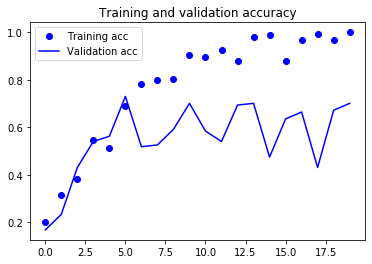

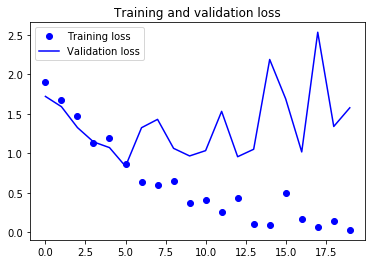

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
Y_pred = model.predict(X_test)

In [12]:
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=classes))

Confusion Matrix
[[ 6 12  1  0  6  0]
 [ 1 12  1  0  9  0]
 [ 0  0 22  0  0  1]
 [ 0  0  0 16  3  0]
 [ 0  3  1  1 25  0]
 [ 0  0  2  0  0 15]]
Classification Report
                    precision    recall  f1-score   support

    CricketBowling       0.86      0.24      0.38        25
       CricketShot       0.44      0.52      0.48        23
FieldHockeyPenalty       0.81      0.96      0.88        23
  HandstandPushups       0.94      0.84      0.89        19
  HandstandWalking       0.58      0.83      0.68        30
     SoccerPenalty       0.94      0.88      0.91        17

          accuracy                           0.70       137
         macro avg       0.76      0.71      0.70       137
      weighted avg       0.74      0.70      0.68       137



## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">منابع</div>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
برای این فایل آموزشی از مخزن زیر کمک گرفته شده است
    </div>
    
https://github.com/harvitronix/five-video-classification-methods

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دوره پیشرفته یادگیری عمیق<br>علیرضا اخوان پور<br>  آبان و آذر 1399<br>
</div>
<a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a> - <a href="https://github.com/Alireza-Akhavan/">GitHub</a>

</div>